# Sentiment Analysis of Twitter Data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import matplotlib as mpl
import matplotlib.pyplot as plt
from gensim.models.word2vec import Word2Vec
from nltk.corpus import stopwords
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import nltk.data 
from sklearn.preprocessing import Imputer
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import TweetTokenizer
from bs4 import BeautifulSoup
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV

In [3]:
#Import csv data into dataframe
tweet_df = pd.read_csv("data/Tweets.csv")

In [4]:
tweet_df.shape

(14640, 15)

In [5]:
#Option set to display all columns
pd.set_option('display.max_columns', None)

#Show first 10 entries
tweet_df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


# Clean up data

In [6]:
#Numbers of nulls per column name
tweet_df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [7]:
#Drop columns due to extremely high number of nulls

delete_columns = ["airline_sentiment_gold","negativereason_gold", "tweet_coord"]

tweet_df.drop(delete_columns, axis=1, inplace=True)

#Show new dataframe without dropped columns
tweet_df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,pilot,0,@VirginAmerica Really missed a prime opportuni...,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,dhepburn,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,YupitsTate,0,"@VirginAmerica it was amazing, and arrived an ...",2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


# Exploratory Data Analysis



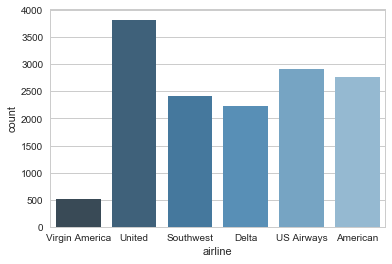

In [8]:
#Count per airline
sns.countplot(x="airline", data=tweet_df, palette="Blues_d");

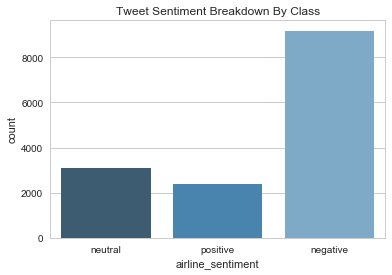

In [9]:
#Count per sentiment
sns.countplot(x="airline_sentiment", data=tweet_df, palette="Blues_d");
plt.title('Tweet Sentiment Breakdown By Class')

In [10]:
tweet_df.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

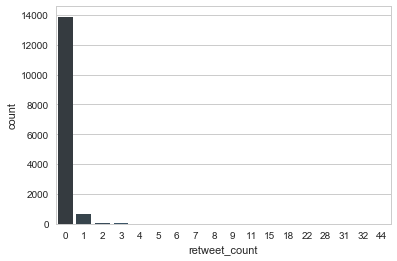

In [11]:
#Count per number of retweets
sns.countplot(x="retweet_count", data=tweet_df, palette="Blues_d");

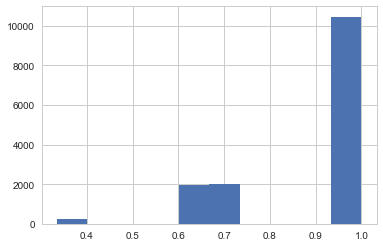

In [12]:
#Historgram of airline sentiment confidence, no normal distribution
tweet_df.airline_sentiment_confidence.hist()

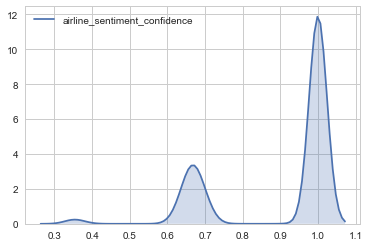

In [13]:
#Kernel density plot of airline sentiment confidence
sns.kdeplot(tweet_df.airline_sentiment_confidence, shade=True)

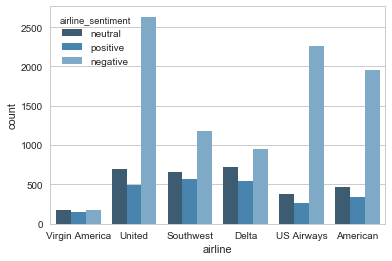

In [14]:
sns.countplot(x="airline", hue="airline_sentiment", data=tweet_df, palette="Blues_d");

# Sentiment Analysis

In [15]:
#Drop all columns except airline sentiment and text

delete_columns = ["tweet_id","airline_sentiment_confidence", "negativereason", "negativereason_confidence",
                  "airline", "name", "retweet_count", "tweet_created", "tweet_location", "user_timezone"]

tweet_df.drop(delete_columns, axis=1, inplace=True)

#Show new dataframe without dropped columns
tweet_df.head(10)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."
7,neutral,@VirginAmerica Really missed a prime opportuni...
8,positive,"@virginamerica Well, I didn't…but NOW I DO! :-D"
9,positive,"@VirginAmerica it was amazing, and arrived an ..."


In [16]:
#Split up training and test 
x_train, x_test, y_train, y_test = train_test_split(tweet_df["text"],tweet_df["airline_sentiment"], test_size=0.3)




In [17]:
def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
 
    review_text = BeautifulSoup(review).get_text()
    
    #review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
    words = review_text.lower().split()
    
    #if remove_stopwords:
        #stops = set(stopwords.words("english"))
        #words = [w for w in words if not w in stops]
 
    return(words)

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words

    raw_sentences = tokenizer.tokenize(review.strip())
    
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence))

    return sentences

In [18]:
sentences = []  

for review in x_train:
    sentences += review_to_sentences(review, tokenizer) 


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://t.co/t9s68korSN" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that documen

In [19]:
sentences[0]

['@usairways', 'am', '2.']

In [20]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 5   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    


# Initialize and train the model (this will take some time)
cbow_model = Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, hs=1)

skip_model = Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sg=1, hs=1)

cbow_model.init_sims(replace=True)
skip_model.init_sims(replace=True)

In [25]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a givenparagraph

    featureVec = np.zeros((num_features,),dtype="float32")
    
    nwords = 0
    
    index2word_set = set(model.wv.index2word)
    
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    
    featureVec = np.divide(featureVec,nwords)
    return featureVec


def getAvgFeatureVecs(reviews, model, num_features):
    
    counter = 0
    
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for review in reviews:
        # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
        
        counter = counter + 1
        
    return reviewFeatureVecs

In [26]:
clean_train_reviews = []
for review in x_train:
    clean_train_reviews.append( review_to_wordlist( review, \
        remove_stopwords=False ))

cbow_train_vecs = getAvgFeatureVecs(clean_train_reviews, cbow_model, num_features)
skip_train_vecs = getAvgFeatureVecs(clean_train_reviews, skip_model, num_features)

clean_test_reviews = []
for review in x_test:
    clean_test_reviews.append( review_to_wordlist( review, \
        remove_stopwords=False ))

cbow_test_vecs = getAvgFeatureVecs(clean_test_reviews, cbow_model, num_features)
skip_test_vecs = getAvgFeatureVecs(clean_test_reviews, skip_model, num_features)

cbow_train_vecs = Imputer().fit_transform(cbow_train_vecs)
skip_train_vecs = Imputer().fit_transform(skip_train_vecs)
cbow_test_vecs = Imputer().fit_transform(cbow_test_vecs)
skip_test_vecs = Imputer().fit_transform(skip_test_vecs)

cbow_train_vecs = scale(cbow_train_vecs)
skip_train_vecs = scale(skip_train_vecs)
cbow_test_vecs = scale(cbow_test_vecs)
skip_test_vecs = scale(skip_test_vecs)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues

In [27]:
# Apply the random over-sampling
ros = RandomOverSampler()

cbow_y_train = y_train

cbow_train_vecs, cbow_y_train = ros.fit_sample(cbow_train_vecs, cbow_y_train)

bern_nb = BernoulliNB()
gaus_nb = GaussianNB()
svc = SVC(kernel="linear", decision_function_shape="ovr")
log = LogisticRegression()

all_models = [
    ("Gaussian Naive Bayes", gaus_nb),
    ("Bernoulli Naive Bayes", bern_nb),
    ("Support Vector Classifier", svc),
    ("Logistic Regression", log)
]

print("Continuous Bag of Words")
print("-------------------------")
for name, model in all_models:
    
    model.fit(cbow_train_vecs, cbow_y_train)
    cbow_y_pred= model.predict(cbow_test_vecs)
    score = accuracy_score(y_test, cbow_y_pred)
    print ("%s : %0.2f" % (name, score))
    

Continuous Bag of Words
-------------------------
Gaussian Naive Bayes : 0.63
Bernoulli Naive Bayes : 0.55
Support Vector Classifier : 0.70
Logistic Regression : 0.69


In [28]:
skip_y_train = y_train

skip_train_vecs, skip_y_train = ros.fit_sample(skip_train_vecs, skip_y_train)

print("Skip-gram")
print("-------------------------")
for name, model in all_models:
    model.fit(skip_train_vecs, skip_y_train)
    skip_y_pred= model.predict(skip_test_vecs)
    score = accuracy_score(y_test, skip_y_pred)
    print ("%s - %0.2f" % (name, score))

Skip-gram
-------------------------
Gaussian Naive Bayes - 0.71
Bernoulli Naive Bayes - 0.63
Support Vector Classifier - 0.73
Logistic Regression - 0.72


Confusion matrix, without normalization
[[2095  433  202]
 [ 189  588  158]
 [ 108  108  511]]
Normalized confusion matrix
[[ 0.77  0.16  0.07]
 [ 0.2   0.63  0.17]
 [ 0.15  0.15  0.7 ]]


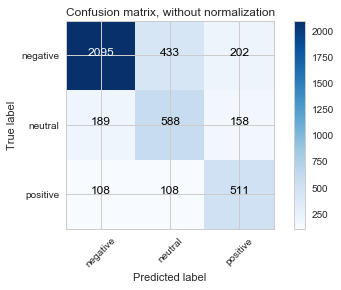

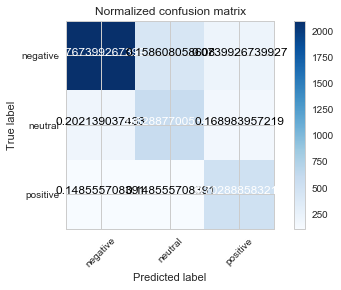

In [29]:

#Confusion Matrix for Support Vector Machine

svc_skip_y_pred= svc.predict(skip_test_vecs)

class_names = ["negative", "neutral", "positive"]
confusion_matrix = confusion_matrix(y_test, svc_skip_y_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    #This function prints and plots the confusion matrix.
    #Normalization can be applied by setting `normalize=True`.
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [30]:
print(classification_report(y_test, skip_y_pred, target_names=class_names))

             precision    recall  f1-score   support

   negative       0.88      0.75      0.81      2730
    neutral       0.52      0.64      0.57       935
   positive       0.58      0.71      0.64       727

avg / total       0.75      0.72      0.73      4392

